In [1]:
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def viewImage(image, name_of_window):
    cv2.namedWindow(name_of_window, cv2.WINDOW_NORMAL)
    cv2.imshow(name_of_window, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

загрузка и изменение размера

In [3]:
image = cv2.imread("1.jpg")
k = image.shape[0]/image.shape[1]
width = 1024
height = int(1024 * k)
dim = (width, height)
# resize image
image = cv2.resize(image, dim)
viewImage(image,'1')

фильтрация

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, threshold_image = cv2.threshold(gray_image, 140, 255, 0)
viewImage(threshold_image, "чб")

In [5]:
kernel = np.ones((2,2),np.uint8)
dilate = cv2.dilate(threshold_image,kernel,iterations=3)

dst = cv2.erode(dilate, kernel,iterations=5)

viewImage(dst, "чб")
im = dst

Разделение на символы

удаление пустых строк сверху и снизу

In [6]:
def del_null_rows(im):
    null_row = [np.all(im[i,:] == 255) for i in range(im.shape[0])]
    if False in null_row:
        not_null_row_arg = null_row.index(False)
    else:
        not_null_row_arg = 0
    if False in list(reversed(null_row)):
        not_null_row_arg_end = list(reversed(null_row)).index(False)
        if not_null_row_arg_end == 0:
            not_null_row_arg_end = 1
    else:
        not_null_row_arg_end = 1
    im = im[not_null_row_arg:-not_null_row_arg_end,:]
    return im


удаление пустых столбцов

In [7]:
def del_null_cols(im):
    null_col = [np.all(im[:,i] == 255) for i in range(im.shape[1])]   
    if False in null_col:
        not_null_col_arg = null_col.index(False)
    else:
        not_null_col_arg = 0
    if False in list(reversed(null_col)):
        not_null_col_arg_end = list(reversed(null_col)).index(False)
        if not_null_col_arg_end == 0:
            not_null_col_arg_end = 1
    else:
        not_null_col_arg_end = 1
    im = im[:,not_null_col_arg:-not_null_col_arg_end]
    return im

In [8]:
im = del_null_rows(im)
im = del_null_cols(im)
im.shape
viewImage(im, "чб")

разделение на символы

In [9]:
def split_nums(im):
    null_col = [np.all(im[:,i] == 255) for i in range(im.shape[1])] 
    space_n = int(im.shape[1]*0.01)
    space = [True for x in range(space_n)]
    nums = []
    while False in null_col:
        space_arg = -1
        for i in range(len(null_col)-space_n):
            if null_col[i:i+space_n] == space:
                space_arg = i
                break
        nums.append(im[:,:space_arg])
        im = im[:,space_arg:]
        im = del_null_cols(im)
        null_col = [np.all(im[:,i] == 255) for i in range(im.shape[1])] 
    return nums

In [10]:
nums = split_nums(im)
#for num in nums:
    #viewImage(num, "чб")

приводим к квадратному виду и 28х28

In [11]:
def to_mnist(im):
    if 255 in im:
        im[im == 0] = 1
        im[im == 255] = 0
    if im.shape[0]>im.shape[1]:
        n = im.shape[0] - im.shape[1]
        field = np.zeros((im.shape[0], int(n/2)))
        im = np.concatenate((field, im, field), axis=1)
        if im.shape[0]!= im.shape[1]:
            im = np.concatenate((im, np.zeros((im.shape[0], 1))), axis=1)
    else: 
        n = im.shape[1] - im.shape[0]
        field = np.zeros((int(n/2),im.shape[1]))
        im = np.concatenate((field, im, field), axis=0)
        if im.shape[0]!= im.shape[1]:
            im = np.concatenate((im, np.zeros((1,im.shape[1]))), axis=0)
    im = cv2.resize(im, (28,28))
    return im


(28, 28)


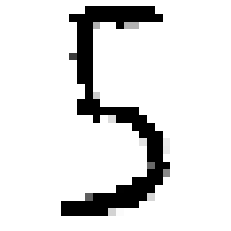

(28, 28)


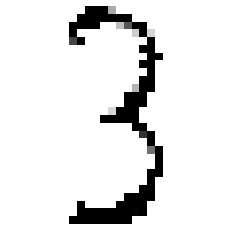

(28, 28)


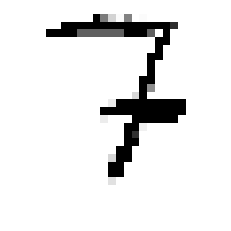

In [12]:
nums28 = []
for i in nums:
    c = to_mnist(i)
    print(c.shape)
    nums28.append(c)
    plt.imshow(c, cmap = matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [13]:
train = pd.read_csv('train.csv')
target = train['label'].values
train.drop('label', axis=1, inplace=True)
train = train.values

In [14]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline # useful to tie the two together

# setting up the components
pca = ('pca', PCA(n_components = 50)) # I did play with the parameter
svc = ('svc', SVC(kernel = 'poly'))

# gluing into a pipe
estimators = [
    pca,
    svc
]
clf = Pipeline(estimators)


from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(train, target, test_size=0.2, random_state=42)

clf.fit(features_train, labels_train)
print(clf.score(features_test, labels_test))

In [15]:
clf.fit(train, target)

F:\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [16]:
test = np.zeros(shape=(len(nums28)+1,784))
for i,num in enumerate(nums28):
    num = np.reshape(num,784)
    test[i] = num
results = clf.predict(test)
results

array([5, 5, 5, 5], dtype=int64)

7


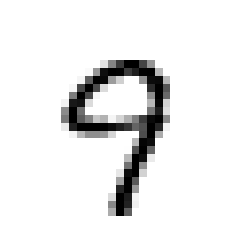

In [17]:
some_digit = train[88]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
print(target[47])
plt.show()

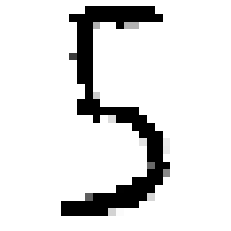

In [18]:
some_digit = test[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()